##  This NoteBook contains data preparation feature engineering, model training/validation for ML Task of DB Schenker 

#### Following is the folder structure. Although seperate scripts are recommended, for sake of simplicity and reduce dependency I included all classes/functions used for training and inference job in respective scripts along with the 'main' orchestration function. 

```
sourish_solution
│─── cost_prediction.csv(Final Prediction File) 
│
└───NB
│   │   Exploratory_train_validation.ipynb(NoteBook - EDA,Data preparation,training,validation)
│   │   inference_scoring.ipynb(NoteBook-scoring process)
│   
└───scripts
|   │   train_validation.py(python scripts for running training job)
|   │   inference.py(python scripts for running scoring/inference job)
|
└───artifacts 
|    │   model.pkl(Final XGB model object during inference)
|    │   ohe.pkl(object to be used for categorical features encoding during inference)
|    |   pt.pkl(object to be used for Power Transformation during inference)
|
|─── requirements.txt(necessary installation to replicate the result) 
    
```
### Steps to run and reproduce the result

- to install necessary packages preferably inside a virtual environment
 - pip install -r requirements.txt
- To run and produce results interactively using NoteBook
- To run and produce results using the individual scripts
     - first to navigate to the scripts folder(cd scripts)
     - python train_validation.py > output.log &
     - python inference.py > output.log &

- To run in the same environment, it's recommened to activate a virtual environment(python/conda)
     - python3 -m venv env
     - source env/bin/activate

### Following are the assumptions

- As I don't know the normalization method of weight, loading_meters, and cost, I used the features as it is w/o any transformation
- The final cost_prediction.csv file contains the predictions with same order w.r.t. the provided test_data.csv

##### Validation data R2 score: 0.8224

#### Adding imports

In [3]:

import os
import math
import pickle
import sys
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import plot_importance
import pickle
import xgboost as xgb
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict,cross_validate,GridSearchCV,RandomizedSearchCV
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler,PowerTransformer
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML
from vincenty import vincenty
from datetime import datetime
import reverse_geocoder as rg
from shapely.geometry import mapping, shape
from shapely.prepared import prep
from shapely.geometry import Point
import requests

## Loading data frame and having a look at the data and checking for any missing value

In [2]:
# data_frame = pd.read_csv('../data/train_data.csv',sep=';', parse_dates=['shipping_date'])
# train_frame, test_data = train_test_split(data_frame, test_size=0.1, random_state=101)
# test_data.to_csv('../data/test_data_hold.csv',index=False)
# train_frame.to_csv('../data/train_data_exp.csv',index=False)
data_frame = pd.read_csv('../data/train_data_exp.csv')
test_data = pd.read_csv('../data/test_data_hold.csv')
data_frame['shipping_date'] = pd.to_datetime(data_frame['shipping_date'])
test_data['shipping_date'] = pd.to_datetime(test_data['shipping_date'])
display(data_frame.head())
data_frame.describe()

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,is_adr,shipping_date,cost
0,26.68,107.82,24.88,105.41,0.447,0.195,True,2018-03-22,0.297
1,26.97,109.94,27.53,112.18,0.441,0.195,True,2017-12-21,0.622
2,25.56,111.41,27.23,105.78,0.083,0.195,True,2018-03-27,0.442
3,26.91,108.67,22.99,110.63,0.464,0.067,True,2017-01-19,0.322
4,24.43,112.24,22.59,104.59,0.504,0.195,True,2019-01-08,0.705


,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,cost
count,226039.000000,226039.000000,226039.000000,226039.000000,226039.000000,226039.000000,226039.000000
mean,25.700418,108.927853,25.585036,108.971544,0.405938,0.167498,0.343943
std,1.783174,2.086830,1.984452,2.298118,0.127710,0.063206,0.130023
min,21.710000,103.000000,21.650000,103.000000,0.050000,0.000000,0.017000
25%,24.310000,107.340000,23.780000,107.180000,0.329000,0.195000,0.249000
50%,25.660000,108.890000,25.640000,109.400000,0.475000,0.195000,0.333000
75%,26.910000,110.460000,27.170000,110.760000,0.490000,0.195000,0.415000
max,30.220000,114.210000,30.400000,114.250000,1.000000,0.995000,2.349000


In [3]:
display(data_frame.info())
data_frame.is_adr.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226039 entries, 0 to 226038
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   origin_latitude        226039 non-null  float64       
 1   origin_longitude       226039 non-null  float64       
 2   destination_latitude   226039 non-null  float64       
 3   destination_longitude  226039 non-null  float64       
 4   weight                 226039 non-null  float64       
 5   loading_meters         226039 non-null  float64       
 6   is_adr                 226039 non-null  bool          
 7   shipping_date          226039 non-null  datetime64[ns]
 8   cost                   226039 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(7)
memory usage: 14.0 MB


None

True    226039
Name: is_adr, dtype: int64

### There in no requirement of missing value treatment
### Only one class for is_adr categorical variable, so the feature is not useful

In [4]:
target = 'cost'
X = data_frame.drop([target],axis=1)
Y = data_frame[target]

# test_X = test_data.drop([target],axis=1)
# y_test = test_data[target]

## Creating a class to first create new features for ML training- Feature Engg.

### Following feature might usefull for the model:
 - From start and end lat-lon a few distence features
 - A few date-time/time series features(week-day,month,year etc.) from 'shipping_date'to capture effect of seasonality 

### creating a class here with a few methods, so that it can be used as an single object during inference time and also have inheritence property

In [5]:
class FeatenggTransformer(BaseEstimator, RegressorMixin, TransformerMixin):

    def transform(self, X):
        
        """This pipeline transforms the dataframe to the desired
         features and shape"""

        X = self.add_date_feature(X)
        X = self.add_travel_features(X)
        X = self.get_country_feats(X)
        X = self.drop_unrequired_fields(X)
        return X

    def add_travel_features(self, X):

        """This Method creates distance features"""
        
        X['abs_diff_longitude'] = (X[lon_2] - X[lon_1]).abs()
        X['abs_diff_latitude'] = (X[lat_2] - X[lat_1]).abs()
        X['Vincenty_distance'] = X.apply(lambda x: vincenty((x[lat_1], \
            x[lon_1]), (x[lat_2], x[lon_2])\
                ,miles=True), axis = 1)

        # bearing (in degrees converted to radians)
        def bearing_array(lat1, lng1, lat2, lng2):
            AVG_EARTH_RADIUS = 6371  # in km
            lng_delta_rad = np.radians(lng2 - lng1)
            lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
            y = np.sin(lng_delta_rad) * np.cos(lat2)
            x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
            return np.degrees(np.arctan2(y, x))

        X['Bearing'] = bearing_array(X[lat_1], \
                    X[lon_1], X[lat_2], X[lon_2])
        X.loc[:, 'center_latitude'] = (X[lat_1].values + X[lat_2].values) / 2
        X.loc[:, 'center_longitude'] = (X[lon_1].values + X[lon_2].values) / 2
        return X

    def add_date_feature(self, X):
        
        """This Method creates time series/date features"""
        
        ref_date = '2017-01-01'
        X['weekday'] = X['shipping_date'].dt.day_of_week
        X["is_weekend"] = np.where(X["weekday"] < 5, 0, 1)
        X['week_in_month'] = pd.to_numeric(X['shipping_date'].dt.day/7).\
        apply(lambda x: math.ceil(x))
        X['month'] = X['shipping_date'].dt.month
        X['day_count'] = (X['shipping_date'] - datetime.strptime(ref_date, "%Y-%m-%d"))/np.timedelta64(1, 'D')
        return X

    def get_country_feats(self, X):
        data = requests.get("https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson").json()
        countries = {}
        for feature in data["features"]:
            geom = feature["geometry"]
            country = feature["properties"]["ADMIN"]
            countries[country] = prep(shape(geom))
        def get_country(row):
            point = Point(row[0], row[1])
            for country, geom in countries.items():
                if geom.contains(point):
                    return country
            return "unknown"
        X['destn_country'] = X[[lon_2,lat_2]].apply(get_country,axis=1)
        X['origin_country'] = X[[lon_1,lat_1]].apply(get_country,axis=1)
        X['diff_country'] = np.where(X['origin_country'] == X['destn_country'],0,1) 
        return X   

    def drop_unrequired_fields(self, X):

        """Method for dropping unrequired fields"""

        return X.drop(['shipping_date','is_adr',lat_1,lon_1,lat_2,lon_2], axis=1)



In [9]:
lat_1,lon_1,lat_2,lon_2 = 'origin_latitude','origin_longitude','destination_latitude','destination_longitude'
fet =  FeatenggTransformer()
X = fet.transform(X)
X.head()
# test_X = fet.transform(test_X)

,weight,loading_meters,weekday,is_weekend,week_in_month,month,day_count,abs_diff_longitude,abs_diff_latitude,Vincenty_distance,Bearing,center_latitude,center_longitude,destn_country,origin_country,diff_country
0,0.447,0.195,3,0,4,3,445.0,2.41,1.80,194.707937,-129.144219,25.780,106.615,China,China,0
1,0.441,0.195,3,0,3,12,354.0,2.24,0.56,143.131553,73.782601,27.250,111.060,China,China,0
2,0.083,0.195,1,0,4,3,450.0,5.63,1.67,367.463504,-70.439856,26.395,108.595,China,China,0
3,0.464,0.067,3,0,3,1,18.0,1.96,3.92,296.511257,155.193431,24.950,109.650,China,China,0
4,0.504,0.195,1,0,2,1,737.0,7.65,1.84,501.643633,-103.147932,23.510,108.415,Vietnam,China,1


## Quick EDA

- weight, loading_meters, and cost have been already normalized
- Let's explore the distribution of newly created numerical features - abs_diff_longitude,abs_diff_latitude,distance

array([[<AxesSubplot:title={'center':'center_longitude'}>]], dtype=object)

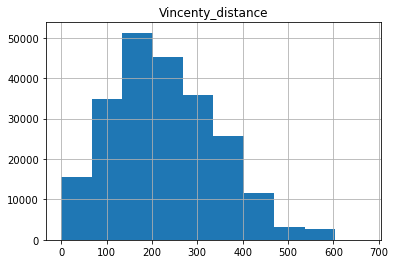

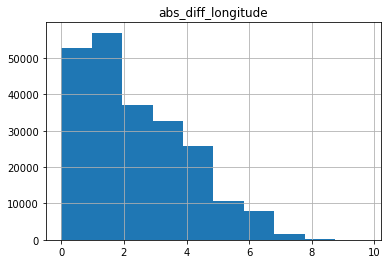

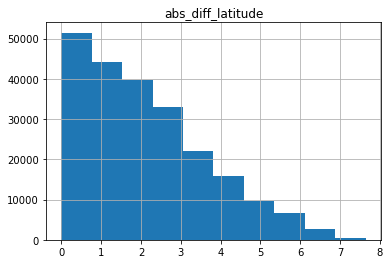

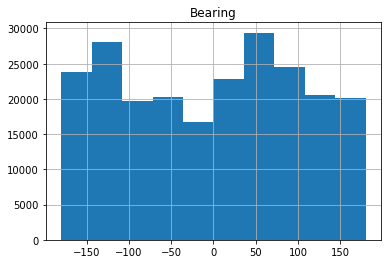

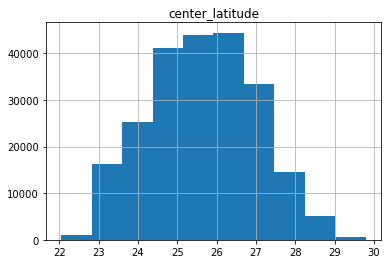

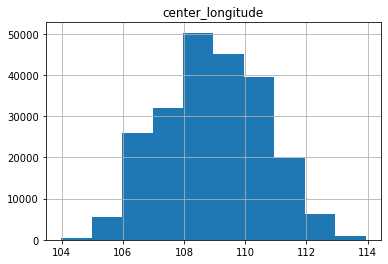

In [239]:
X.hist('Vincenty_distance')
X.hist('abs_diff_longitude')
# X1 = m.fit_transform(np.array(X['abs_diff_latitude']).reshape(-1, 1)) 
# hist(X1)
X.hist('abs_diff_latitude')
X.hist('Bearing')
X.hist('center_latitude')
X.hist('center_longitude')

- Feature distance has relatively different scale and have outlier effect. Also distribution of abs_diff_longitude and abs_diff_latitude is right skewed and contain large outliers.  
- These two characteristics may degrade the predictive performance of machine learning algorithms. Unscaled data can also slow down or even prevent the convergence ofgradient-based estimators. So we may need some scaling/normalization. 

## Feature Transformation

- A) One-Hot Encoding: For these categorical variables there no definite ordinal relationship exists,so the integer encoding(LabelEncoder/LabelBinarizer) is not enough.

- B) Feature scaling: We are going to use XGBoost algorithm.Strictly
XGBoost with a tree base learner would not require explicit data standardisation. However, probably it will help numerically for gradient calculations and to converge faster when features are on a relatively similar scale and/or close to normally distributed.Apart from MinMaxScaling following standardization(distribution shift)based approach can be explored.
   - StandardScaler 
   - RobustScaler
   - Power Transformer
   - QuantileTransformer(Gaussian output)

As with non-gaussian, right skewed distribution for abs_diff_longitude and abs_diff_latitude(with a presense of a large outliers) we choose PowerTransformer to make the data more Gaussian-like in order to stabilize variance and minimize skewness. Also it would be less sensitive to outliers.By default, PowerTransformer applies zero-mean, unit variance normalization.For 'distance'feature it will be MinMaxScaling. 

In [10]:
#Segregate Categorical and Numerical features

cat_cols = ['week_in_month', 'weekday', 'is_weekend', 'month','destn_country','origin_country']
num_cols = [col for col in list(X.columns) if col not in cat_cols]
print(num_cols)

['weight', 'loading_meters', 'day_count', 'abs_diff_longitude', 'abs_diff_latitude', 'Vincenty_distance', 'Bearing', 'center_latitude', 'center_longitude', 'diff_country']


In [11]:
from sklearn.preprocessing import MinMaxScaler


class FeatureTransformer(BaseEstimator, RegressorMixin, TransformerMixin):

    """This Class is for FeatureTransform
        a) categorical feature encoding
        b) feature scaling
    """
    
    def __init__(self,cat_cols,num_cols,path):
        self.cat_cols,self.num_cols,self.path = cat_cols,num_cols,path
        if not os.path.exists(self.path):
            os.mkdir(self.path)
    def transform(self, X):

        """This pipeline transforms the categorical features to One-Hot Encoded and scales the 
         features"""

        X = self.encode_categorical(X)
        # X = self.scale_features(X)
        return X

    def encode_categorical(self, X):

        """This Method creates absolute difference features
        and Serializes(pickle) the necessary objects for inference"""

        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        ohe.fit(X[self.cat_cols])
        x_cat_df = pd.DataFrame(ohe.transform(X[self.cat_cols]))
        x_cat_df.columns = ohe.get_feature_names_out(self.cat_cols)
        # X = X[num_cols].reset_index(drop=True).join(x_cat_df)
        X = pd.concat([X[num_cols],x_cat_df],axis=1)
        with open(os.path.join(self.path,'ohe.pkl') ,'wb') as fout:
            pickle.dump(ohe, fout)
        return X

    def scale_features(self, X):
        
        """This Method scales features before feeding into ML training
        and Serializes(pickle) the necessary objects for inference"""

        # std_feats = ['abs_diff_longitude', 'abs_diff_latitude']
        # pt = PowerTransformer().fit(X[std_feats])
        # X[std_feats] = pd.DataFrame(pt.transform(X[std_feats]))
        # with open(os.path.join(self.path,'pt.pkl'), 'wb') as fout:
        #     pickle.dump(pt, fout)
            
        #MaxScaler for distance
        scaling_feats = ['Vincenty_distance','Bearing','center_latitude', 'center_longitude'] 
        MMS = MinMaxScaler().fit(X[scaling_feats]) 
        X[scaling_feats] = MMS.transform(X[scaling_feats]) 
           
        # max_val, min_val = X['Vincenty_distance'].max(),X['Vincenty_distance'].min()
        # X['Vincenty_distance'] = (X['Vincenty_distance']-min_val)/(max_val-min_val) 
        # max_val, min_val = X['Vincenty_distance'].max(),X['Vincenty_distance'].min()
        # X['Vincenty_distance'] = (X['distance']-min_val)/(max_val-min_val)

        return X
        

In [12]:
ft = FeatureTransformer(cat_cols=cat_cols,num_cols=num_cols,path='../artifacts/')
X_transformed = ft.transform(X)
print(X_transformed.shape)
# test_X_transformed = ft.transform(test_X)
# X_transformed.hist('abs_diff_latitude')
# X_transformed.hist('abs_diff_longitude')
# X_transformed.hist('center_latitude')
# X_transformed.hist('Bearing')

(226039, 40)


In [104]:
# h2o.init(
#     nthreads=-1,     # number of threads when launching a new H2O server
#     max_mem_size=12  # in gigabytes
# )
# data_frame = pd.concat([X_transformed,Y], axis = 1)

# train_data, test_data = train_test_split(data_frame, test_size=0.1, random_state=101)
# train = h2o.H2OFrame(train)
# test = h2o.H2OFrame(test)
# x = train.columns
# y = "cost"
# aml = H2OAutoML(max_models=10, seed=1)
# aml.train(x=x, y=y,training_frame=train)
# preds = aml.leader.predict(test)
# r2_score(preds.as_data_frame(), test_data['cost'])

### The distributions looks better now

### Before modelling let's explore interesting patterns/correlation between the numerical variables and cost

origin_latitude          0.035061
origin_longitude         0.000688
destination_latitude     0.072866
destination_longitude    0.041480
weight                  -0.051096
loading_meters           0.047591
year                     0.055111
day_count                0.079245
abs_diff_longitude       0.596221
abs_diff_latitude        0.521580
Vincenty_distance        0.780804
Bearing                 -0.005516
center_latitude          0.076610
center_longitude         0.029554
diff_country             0.070666
Name: cost, dtype: float64

<AxesSubplot:>

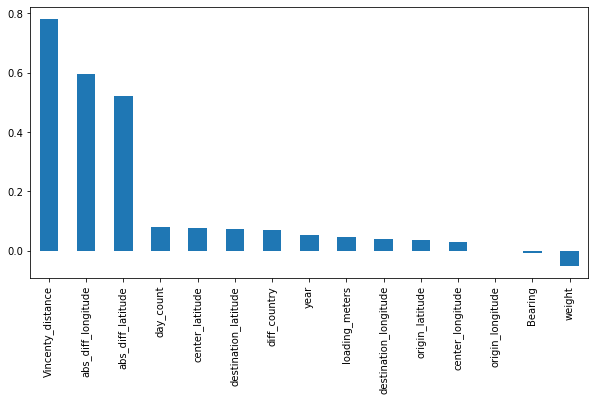

In [502]:
plt.figure(figsize=(10,5))
display(pd.concat([X_transformed[num_cols],Y],axis=1).corr()['cost'][:-1])
pd.concat([X_transformed[num_cols],Y],axis=1).corr()['cost'][:-1].sort_values(ascending = False).plot(kind='bar')
# plt.show()

### As expected very high +ve correlation between cost and distance(as reflected for abs_diff_longitude and abs_diff_latitude as well).Will keep in mind for building Monotonic relationship.
### Surprisingly there is no or little correlation for loading_meters and weight.However will look into the partial dependency plot as guiding principle               

## Model Training

#### For time constraint and for simplicity I will limit in developing XGBoost model only as generally perform decently well amongst all classic ML algorithms

#### Before writing ML training pipeline let's explore the benchmark model

## Base Model

In [509]:
import scipy
xgb_params = { 
    'max_depth': 7,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'early_stopping_rounds':20,
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'silent': 2,
    'seed':100
}

# def rsquared(x, y):
#     """ Return R^2 where x and y are array-like."""

#     slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
#     return r_value**2
#Splitting data into training and valid with 80:20 split
X_train, X_valid, y_train, y_valid = train_test_split(X_transformed, Y, test_size=0.2, random_state=101)
feature_names = X_transformed.columns.drop(['year','origin_latitude', 'origin_longitude', 'destination_latitude',
       'destination_longitude'])
dtrain = xgb.DMatrix(X_train.drop(['year','origin_latitude', 'origin_longitude', 'destination_latitude',
       'destination_longitude'],axis=1), y_train, feature_names = feature_names)
dvalid = xgb.DMatrix(X_valid.drop(['year','origin_latitude', 'origin_longitude', 'destination_latitude',
       'destination_longitude'],axis=1), y_valid, feature_names = feature_names)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
dtest = xgb.DMatrix(test_X_transformed.drop(['year','origin_latitude', 'origin_longitude', 'destination_latitude',
       'destination_longitude'],axis=1), y_test, feature_names = feature_names)
model = xgb.train(xgb_params, dtrain, 1000,watchlist,early_stopping_rounds=50)
pred = np.array(model.predict(dtest).reshape(-1,1))
print(f'R2 score: {r2_score(y_test, pred)}')
print(f'Mean absolute percentage error(MAPE): {mean_absolute_percentage_error(y_test,pred)}')
print(f'Mean absolute error(MAE): {mean_absolute_error(y_test,pred)}') 

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[07:54:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	eval-rmse:0.19352	train-rmse:0.19429
[1]	eval-rmse:0.18518	train-rmse:0.18593
[2]	eval-rmse:0.17719	train-rmse:0.17792
[3]	eval-rmse:0.16987	train-rmse:0.17056
[4]	eval-rmse:0.16283	train-rmse:0.16349
[5]	eval-rmse:0.15626	train-rmse:0.15691
[6]	eval-rmse:0.14991	train-rmse:0.15055
[7]	eval-rmse:0.14391	train-rmse:0.14453
[8]	eval-rmse:0.13881	train-rmse:0.13939
[9]	eval-rmse:0.13349	train-rmse:0.13405
[10]	eval-rmse:0.12850	train-rmse:0.12904
[11]	eval-rmse:0.12384	train-rmse:0.12435
[12]	eval-rmse:0.11953	train-rmse:0.12002
[13]	eval-rmse:0.11541	t

- R2 score is decent, however to explore possibility to make better

### The partial dependency describes that when other variables fixed, how the average response depends on a predictor.

### Intuitively there would be monotonic  relationship between cost and distance and cost and weight.Will check for applicable monotonicity constraint, as it might increase model explainability and hence R2 score

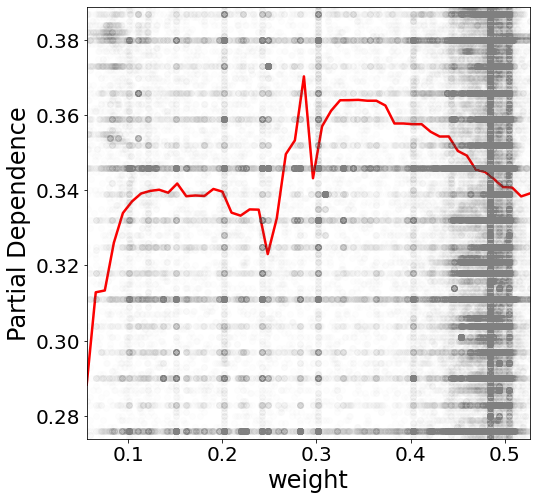

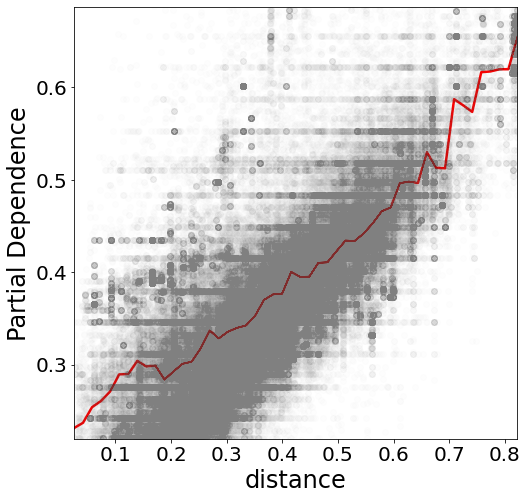

In [47]:
def partial_dependency(model, X, y, feature_ids = [], f_id = -1):

    """
    Helper Function to Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    """

    X_temp = X.copy()

    grid = np.linspace(np.percentile(X_temp.iloc[:, f_id], 0.1),
                       np.percentile(X_temp.iloc[:, f_id], 99.5),
                       50)
    y_pred = np.zeros(len(grid))

    if len(feature_ids) == 0 or f_id == -1:
        print ('Input error!')
        return
    else:
        for i, val in enumerate(grid):

            X_temp.iloc[:, f_id] = val
            data = xgb.DMatrix(X_temp, feature_names = feature_names)
            y_pred[i] = np.average(model.predict((data)))

    return grid, y_pred

#Check for partial dependency distance and weight feature

monotone_feature_names = ['weight','distance']
feature_monotones = [0 if f not in monotone_feature_names else 1 for f in feature_names]
feature_ids = [i for i in range(len(feature_names))]

for f in monotone_feature_names:
    f_id = feature_names.tolist().index(f)

    feature_ids = range(X.shape[1])
    grid, y_pred = partial_dependency(model,
                                      X_transformed,
                                      Y,
                                      feature_ids = feature_ids,
                                      f_id = f_id
                                      )

    fig, ax = plt.subplots()
    fig.set_size_inches(8, 8)
    plt.subplots_adjust(left = 0.17, right = 0.94, bottom = 0.15, top = 0.9)

    ax.plot(grid, y_pred, '-', color = 'red', linewidth = 2.5, label='fit')
    ax.plot(X_transformed.iloc[:, f_id], Y, 'o', color = 'grey', alpha = 0.01)

    ax.set_xlim(min(grid), max(grid))
    ax.set_ylim(0.95 * min(y_pred), 1.05 * max(y_pred))

    ax.set_xlabel(f, fontsize = 24)
    ax.set_ylabel('Partial Dependence', fontsize = 24)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.show()


#### Although inconclusive for weight for distance there is definitely a relationship.So will apply monotonicity constraint(monotone_constraints)in finetuned XGB model 

## Finetuned model

### XGBoost Model optimization- through grid serach hyperparameter tuning 

### As key evaluation metric, relevant for this business problem here we try to maximize R-Squared score.

#### For illustration we will vary few key hyper parameters- depth,learning_rate,colsample and subsample rate of XGB algorithm and will pick the hyper parameter setting,which will give maximum performance(highest R2).Of course there are many more hyper parameters we can play with.

#### Following pipeline will make ML-training, validation and save the model object for inference

In [15]:
class TrainValidateMod(BaseEstimator,TransformerMixin):

    """Splitting data, Model training and Hyperparameter tuning with CrossValidation 
       and testing best Hyperparameter tuned model on validation data and save the model
    """

    def __init__(self, model_path = None):
        self.model_path  = model_path
            
    def fit(self,X,Y):

        """Method to Split data, Model training and Hyperparameter tuning with CrossValidation 
        """
        monotone_feature_names = ['distance']
        feature_monotones = [0 if f not in monotone_feature_names else 1 for f in feature_names]

        X_train, self.X_valid, y_train, self.y_valid = train_test_split(X, Y, test_size=0.2, random_state=101)

        #Hyperparameter tuning using GridSearch
        
        ind_params = {'n_estimators': 300, 'seed':100,'learning_rate': 0.05}
        ind_params['nthread'] = 4
        ind_params['eval_metric'] = 'r2'
        ind_params['monotone_constraints'] = '(' + ','.join([str(m) for m in feature_monotones]) + ')'
        xgb_model = XGBRegressor(eval_metric = 'rmse',objective='reg:squarederror')

        #Grid spec
        GV = GridSearchCV(xgb_model,
                        {'max_depth': [5,6,7],'subsample': [0.7,0.8], 'colsample_bytree': [0.4,0.7,0.8], 'learning_rate':[0.05],
                            'gamma':[0.005,0.01],},cv=3,scoring='r2',refit=True,verbose=2)
        GV.fit(X_train, y_train)
        print(f' Best Model Parameter {GV.best_params_}')
        print(f' Best Model CV score {GV.best_score_}')
        print(f'selecting the best Hyperparameter tuned estimator with {GV.best_params_}')     
        self.model = GV.best_estimator_

        #best model refit with higher n_estimators and early_stopping_rounds to avoid overfit
        self.model.n_estimators = 1500
        display(self.model)
        self.model.fit(X_train, y_train,verbose=0,\
            early_stopping_rounds=20,eval_set=[(X_train, y_train), (X_valid, y_valid)]) 
        return self.model,self.X_valid,self.y_valid
        
    def validation(self):

        """Method to test best Hyperparameter tuned model on validation data and save model"""

        pred = self.model.predict(self.X_valid)
        print(f'R2 score: {r2_score(self.y_valid,pred)}')
        print(f'Mean absolute percentage error(MAPE): {mean_absolute_percentage_error(self.y_valid,pred)}')
        print(f'Mean absolute error(MAE): {mean_absolute_error(self.y_valid,pred)}')

        with open(self.model_path, 'wb') as fout:
            pickle.dump(self.model, fout)
        return pred    

#### Implementing the class to get model object and 

In [16]:
TV = TrainValidateMod('../artifacts/model.pkl')
model,X_valid,y_valid = TV.fit(X_transformed,Y=Y)
pred = TV.validation()

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, subsample=0.7; total time=   3.4s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, subsample=0.7; total time=   3.2s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, subsample=0.7; total time=   3.3s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, subsample=0.8; total time=   4.2s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, subsample=0.8; total time=   6.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, subsample=0.8; total time=   4.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=7, subsample=0.7; total time=   6.0s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=7, subsample=0.7; total time=   6.4s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', gamma=0.01, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1500,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


R2 score: 0.8224285111891971
Mean absolute percentage error(MAPE): 0.10917381254608503
Mean absolute error(MAE): 0.03352929927120023


- There is approx. 4.5% improvment on R2 score over the base model.Also the error metrics look better 

### Explore feature importance

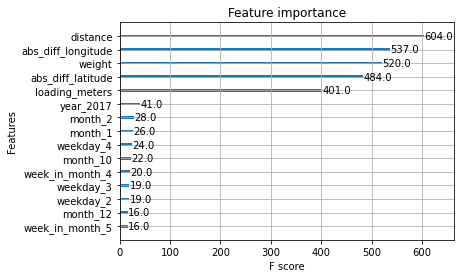

<Figure size 720x18000 with 0 Axes>

In [54]:
from matplotlib import pyplot as plt
plot_importance(model, importance_type='weight', max_num_features=15)
plt.figure(figsize=(10,250))
plt.show()

#### Prediction Diagnosis- Actual vs. Prediction

predicted mean:0.34360960125923157
actual mean:0.34358800342419443


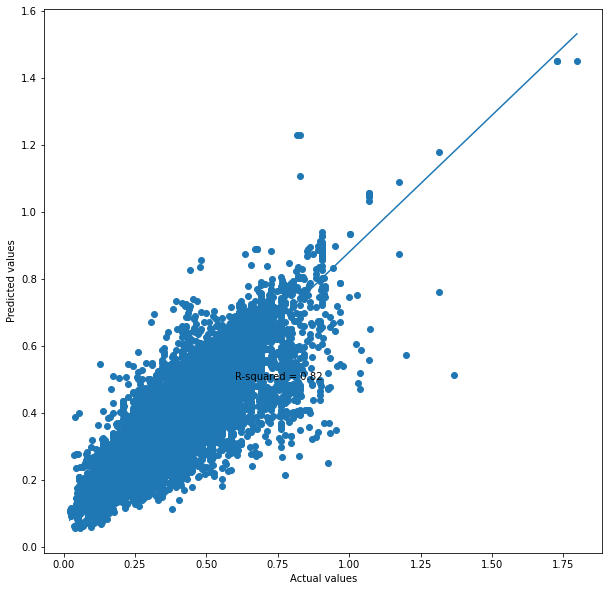

In [18]:
pred = TV.model.predict(TV.X_valid)
print(f'predicted mean:{pred.mean()}')
print(f'actual mean:{y_valid.mean()}')
r_squared = r2_score(TV.y_valid,pred)
# print(r_squared)
plt.figure(figsize=(10,10))
plt.scatter(y_valid,pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(y_valid), np.poly1d(np.polyfit(y_valid, np.array(pred).reshape(-1), 1))(np.unique(y_valid)))

plt.text(0.6, 0.5, 'R-squared = %0.2f' % r_squared)
plt.show()

### Scope for further improvement

#### A) Although level of predicted mean and actual mean matches, however there is a scope to improve the prediction for extreme values, especially extreme high values

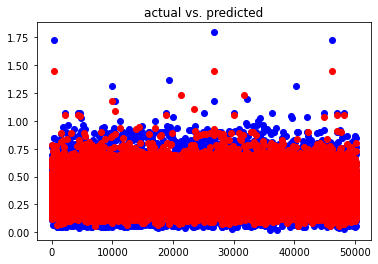

max actual 1.797
max prediction 1.450529932975769


In [20]:
def plotGraph(y_test,y_pred,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='red')
    plt.title(regressorName)
    plt.show()
    return


# y_test = range(10)
# y_pred = np.random.randint(0, 10, 10)

plotGraph(y_valid, pred, "actual vs. predicted")
print(f'max actual {y_valid.max()}')
print(f'max prediction {pred.max()}')

- Although not significant and mostly related to outliers to address this under prediction issue we may try following:
    - Segmented model approach(for example seperate models for very long distance or seperate model for a seperate season)
    - Quantile regression model especially for extreme high values and use this to predict for few highest/lowest quantiles for most explainable features
    https://scikit-learn.org/stable/auto_examples/linear_model/plot_quantile_regression.html

B) Explore other ML techniques
 - Penalized Regression Techniques(Lasso/Ridge/ElasticNet/BayesianRidge etc.), Bagging based techniques(Random Forest) 
 - Also for bigger data finetuned ANN can be tried with Embeddings based features

C) Hyperparameter Tuning
    - HyperOpt leveraging Bayesian Optimization for more efficient solution

D) Feature Engg.
    - On real time system I won't use 'Year' feature as it may not score properly for the years, not present in training data. Rather I may use a time series(day no count)to capture possible macroeconomic factors(eg.inflation)
    - From my limited domain knowledge I used only haversine distance, other distance measeures can be used
    - Clustering approach(ML or Business rule based) to group start and end lat-longs also may act as a guiding priciple for precise prediction.  

In [334]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
SEED = 100
VALID_SIZE = 0.2
def obj (params):
  xgb_model=xgb.XGBRegressor(
      n_estimator=params['n_estimator'],
      learning_rate=params['learning_rate'],
      booster=params['booster'],
      gamma=params['gamma'],
      max_depth=int(params['max_depth']),
      min_child_weight=int(params['min_child_weight']),
      colsample_bytree=int(params['colsample_bytree']),
      reg_lambda=params['reg_lambda'],reg_alpha=params['reg_alpha']
  )
  evaluation=[(X_train,y_train),(X_valid,y_valid)]
  xgb_model.fit(X_train,y_train,early_stopping_rounds=30,
            eval_set=evaluation,
            verbose=False)
  pred = xgb_model.predict(X_valid)
  r2_value=r2_score(y_true=y_valid,y_pred=pred)
  mape=mean_absolute_percentage_error(pred,y_valid)
  print('R2-Value:',r2_value)
  print('MAPE Value :',mape)
  print(xgb_model.get_params)
  return {'loss': -r2_value, 'status': STATUS_OK ,'model':xgb_model }
  
params={'n_estimator':1000,
        'learning_rate':hp.uniform('learning_rate',0.01,0.06),
        'booster':hp.choice('booster',['gbtree']),
        'reg_lambda':hp.uniform('reg_lambda',0,2.5),
        'reg_alpha':hp.uniform('reg_alpha',0,2.5),
        'colsample_bytree':hp.uniform('colsample_bytree',0.4,0.9),
        'gamma':hp.uniform('gamma',0,10),
        'subsample': hp.quniform('subsample', 0.5, 0.8, 0.05),
        'max_depth':hp.quniform('max_depth',3,8,1),
        'seed': 200,
        'min_child_weight':hp.quniform('min_child_weight',1,5,1)}

trials = Trials()
best_hyperparams = fmin(fn = obj,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

[20:19:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2-Value:                                             
0.30577782752680005                                   
MAPE Value :                                          
0.23602942325346624                                   
<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=1.7667169217229384, gpu_id=-1,
             grow_policy='depthwise', importance_ty

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



R2-Value:                                                                         
0.31754042975265573                                                               
MAPE Value :                                                                      
0.2338358770776336                                                                
<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=6.426142901160748, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.03858011601480136,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=5,
             max_leaves=0, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimator=1000, n_estimators=100,
          

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



R2-Value:                                                                         
0.0922601335675799                                                                
MAPE Value :                                                                      
0.2583203897998877                                                                
<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=4.7192572896438145, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.015267983522355297,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
             max_leaves=0, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimator=1000, n_estimators=100,
        

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



R2-Value:                                                                         
0.39587974936766135                                                               
MAPE Value :                                                                      
0.21906317719026355                                                               
<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=8.39480078384344, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05527748958851598,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=5,
             max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimator=1000, n_estimators=100,
           

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



R2-Value:                                                                         
0.26827379185471334                                                               
MAPE Value :                                                                      
0.2413973864015363                                                                
<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.4231702334369969, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.02929195478422912,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=5,
             max_leaves=0, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimator=1000, n_estimators=100,
         

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



R2-Value:                                                                         
0.23857696669129724                                                               
MAPE Value :                                                                      
0.24573414374875052                                                               
<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=8.904283694517401, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.029003000002758392,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=3,
             max_leaves=0, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimator=1000, n_estimators=100,
         

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



R2-Value:                                                                         
0.22940707305951913                                                               
MAPE Value :                                                                      
0.24648297149139148                                                               
<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=4.427791124726773, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.024293865260443994,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=7,
             max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimator=1000, n_estimators=100,
         

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



R2-Value:                                                                         
0.2601763118028311                                                                
MAPE Value :                                                                      
0.2427959627470224                                                                
<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=4.515926505576283, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.02780453558696163,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=7,
             max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimator=1000, n_estimators=100,
          

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



R2-Value:                                                                         
0.25680615437847676                                                               
MAPE Value :                                                                      
0.2432096301673107                                                                
<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.9837913386106945, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.030855581909123304,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=3,
             max_leaves=0, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimator=1000, n_estimators=100,
        

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



R2-Value:                                                                         
0.27322667293346115                                                               
MAPE Value :                                                                      
0.24077192553259005                                                               
<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=4.851583069897837, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.03207800979373991,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=4,
             max_leaves=0, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimator=1000, n_estimators=100,
          

In [558]:
from sklearn.linear_model import ElasticNetCV, LinearRegression
## model stacking
# drop_feat = ['origin_latitude', 'origin_longitude', 'destination_latitude',
#        'destination_longitude','year']
# model_path = os.path.join('../artifacts/','lgb_model.pkl')
# with open(model_path,'rb') as fout:
#     lgb = pickle.load(fout)
# model_path = os.path.join('../artifacts/','model.pkl')
# with open(model_path ,'rb') as fout:
#     xgb = pickle.load(fout)
# model_path = os.path.join('../artifacts/','rf_model.pkl')
# with open(model_path ,'rb') as fout:
#     rf = pickle.load(fout)
# scored_data = pd.DataFrame({'pred_xgb':list(xgb.predict(X_transformed.drop(drop_feat,axis=1))),'pred_lgb':list(lgb.predict(X_transformed.drop(drop_feat,axis=1))),
# 'pred_rf':list(rf.predict(X_transformed.drop(drop_feat,axis=1)))})
# scored_data_train, scored_data_valid, y_train, y_valid = train_test_split(scored_data, Y, test_size=0.2, random_state=101)
# lm = LinearRegression()
# lm.fit(X = scored_data, y = Y)
# model_path = os.path.join('../artifacts/','stacked_lm.pkl')
# with open(model_path,'wb') as fout:
#     pickle.dump(lm,fout)

# xg = XGBRegressor(base_score=0.5, booster='gbtree', 
#              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
#              early_stopping_rounds=50, enable_categorical=False,
#              eval_metric='rmse', gamma=0.01,
#              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
#              max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=1,
#              monotone_constraints='()', n_estimators=1000,
#              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
#              reg_alpha=0, reg_lambda=1)
# xg.fit(X = scored_data_train, y = y_train, eval_set=[(scored_data_train, y_train), (scored_data_valid, y_valid)])
# model_path = os.path.join('../artifacts/','stacked_xgb.pkl')
# with open(model_path,'wb') as fout:
#     pickle.dump(xg,fout)  
# 
# from sklearn.linear_model import BayesianRidge 
# param_test ={
#              'fit_intercept': [True,False], 
#              'lambda_2': [1e-6,1e-6, 1e-3, 1e-2, 1e-1, 1, 1e1],
#              'lambda_1': [1e-6,1e-6,1e-3, 1e-2, 1e-1, 1, 1e1], 
#              'alpha_1': [1e-06, 1e-05, 1e-03, 1, 5],
#              'alpha_2': [1e-06, 1e-05, 1e-03, 1, 5]}
# n_HP_points_to_test = 50
# br = BayesianRidge(verbose=True)
# gs = RandomizedSearchCV(
#     estimator=br, param_distributions=param_test, 
#     n_iter=n_HP_points_to_test,
#     scoring='r2',
#     cv=2,
#     refit=True,
#     random_state=314,
#     verbose=True)
# gs.fit(X_transformed.drop(drop_feat,axis=1), Y)
br = gs.best_estimator_
                      
br.fit(X_transformed.drop(['year','origin_latitude', 'origin_longitude', 'destination_latitude',
       'destination_longitude'],axis = 1), Y) 

pred = br.predict(test_X_transformed.drop(['year','origin_latitude', 'origin_longitude', 'destination_latitude',
       'destination_longitude'],axis = 1))

print(r2_score(y_test,pred))
mean_absolute_percentage_error(y_test,pred) 

Convergence after  2  iterations
0.6432548251696879


0.17079161429415968

### More date features

array([[<AxesSubplot:title={'center':'cost'}>]], dtype=object)

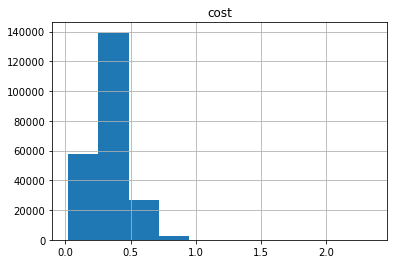

In [57]:
train_data_feature.hist('cost')

In [51]:
#When the data is distributed in a different way in each quantile of the data set, it may be advantageous to fit a different regression model to meet 
# the unique modeling needs of each quantile instead of trying to fit a one-size-fits-all model that predicts the conditional mean. In such cases, 
# the coefficients of all such quantile models would differ from each other.
from sklearn.linear_model import QuantileRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf
# mod = smf.quantreg("cost ~ Vincenty_distance", train_data_feature)

quantiles = np.arange(0.95, 0.995, 0.005)


def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params["Intercept"], res.params["Vincenty_distance"]] + res.conf_int().loc[
        "Vincenty_distance"
    ].tolist()


models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=["q", "a", "b", "lb", "ub"])

ols = smf.ols("cost ~ Vincenty_distance", train_data_feature).fit()
ols_ci = ols.conf_int().loc["Vincenty_distance"].tolist()
ols = dict(
    a=ols.params["Intercept"], b=ols.params["Vincenty_distance"], lb=ols_ci[0], ub=ols_ci[1]
)

print(models)
print(ols)

       q         a         b        lb        ub
0  0.950  0.310605  0.000766  0.000753  0.000778
1  0.955  0.314313  0.000785  0.000773  0.000797
2  0.960  0.322316  0.000799  0.000782  0.000815
3  0.965  0.327982  0.000834  0.000816  0.000851
4  0.970  0.329517  0.000892  0.000881  0.000902
5  0.975  0.328096  0.000976  0.000963  0.000989
6  0.980  0.330684  0.001069  0.001051  0.001087
7  0.985  0.325424  0.001259  0.001238  0.001280
8  0.990  0.354026  0.001308  0.001281  0.001335
9  0.995  0.400804  0.001407  0.001353  0.001462
{'a': 0.14140171106396443, 'b': 0.0008811408738091793, 'lb': 0.0008782342526342904, 'ub': 0.0008840474949840682}


One more thing we notice is that the partial effect of Vincenty_distance on the cost (i.e. the coefficient of Vincenty_distance) increases with the quantile number, indicating that the higher quantile costs are more sensitive than lower quantile costs to changes in Vincenty_distance. For instance, the 99.5th percentile cost changes more with each unit change in the Vincenty_distance than the 95th percentile cost.

Text(0, 0.5, 'cost')

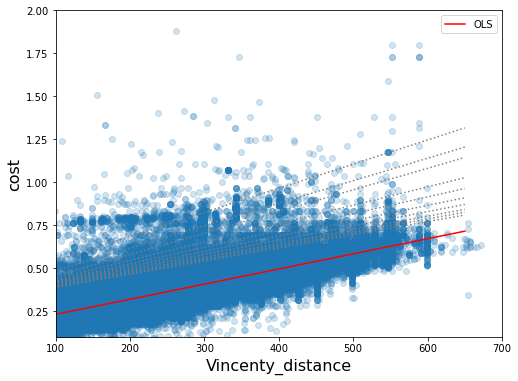

In [53]:
x = np.arange(train_data_feature.Vincenty_distance.min(), train_data_feature.Vincenty_distance.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle="dotted", color="grey")

y = get_y(ols["a"], ols["b"])

ax.plot(x, y, color="red", label="OLS")
ax.scatter(train_data_feature.Vincenty_distance, train_data_feature.cost, alpha=0.2)
ax.set_xlim((100, 700))
ax.set_ylim((0.1, 2))
legend = ax.legend()
ax.set_xlabel("Vincenty_distance", fontsize=16)
ax.set_ylabel("cost", fontsize=16)

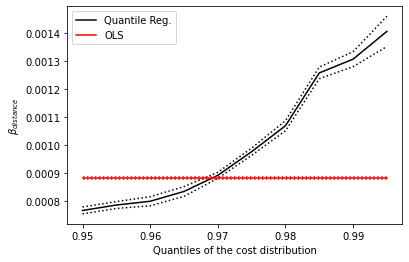

In [55]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color="black", label="Quantile Reg.")
p2 = plt.plot(models.q, models.ub, linestyle="dotted", color="black")
p3 = plt.plot(models.q, models.lb, linestyle="dotted", color="black")
p4 = plt.plot(models.q, [ols["b"]] * n, color="red", label="OLS")
p5 = plt.plot(models.q, [ols["lb"]] * n, linestyle="dotted", color="red")
p6 = plt.plot(models.q, [ols["ub"]] * n, linestyle="dotted", color="red")
plt.ylabel(r"$\beta_{distance}$")
plt.xlabel("Quantiles of the cost distribution")
plt.legend()
plt.show()

In [40]:
# from fastai.tabular.core import add_datepart
import holidays
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
data_frame = pd.read_csv('../data/train_data_exp.csv')
data_frame['holiday'] = data_frame['shipping_date'].apply(lambda x: x in  holiday)
train_data_feature = pd.read_csv('../data/train_data_with_features.csv')
data_frame = add_datepart(data_frame,'shipping_date')
# holiday = holidays.China()

print(data_frame.shape)
other_time_feat = [ 'shipping_Is_month_end',
       'shipping_Is_month_start', 'shipping_Is_quarter_end',
       'shipping_Is_quarter_start', 'shipping_Is_year_end',
       'shipping_Is_year_start','shipping_Week','holiday']
train_data_feature[other_time_feat] = data_frame[other_time_feat]
rest = [col for col in train_data_feature.columns if col not in other_time_feat]
train_data_feature = pd.concat([train_data_feature[rest],train_data_feature[other_time_feat].apply(LabelEncoder().fit_transform)],axis=1)
# train_data_feature[other_time_feat] = lb.fit_transform(train_data_feature[other_time_feat])
# train_data_feature.head()

train_data_feature.to_csv('../data/train_data_with_features.csv',index=False)
test_data = pd.read_csv('../data/test_data_hold.csv')
test_data['holiday'] = test_data['shipping_date'].apply(lambda x: x in  holiday)
test_data_feature = pd.read_csv('../data/test_data_with_features.csv')
test_data = add_datepart(test_data,'shipping_date')
# holiday = holidays.China()
# other_time_feat = [ 'shipping_Is_month_end',
#        'shipping_Is_month_start', 'shipping_Is_quarter_end',
#        'shipping_Is_quarter_start', 'shipping_Is_year_end',
#        'shipping_Is_year_start','shipping_Week','holiday']
test_data_feature[other_time_feat] = data_frame[other_time_feat]
rest = [col for col in test_data_feature.columns if col not in other_time_feat]
test_data_feature = pd.concat([test_data_feature[rest],test_data_feature[other_time_feat].apply(LabelEncoder().fit_transform)],axis=1)
test_data_feature.to_csv('../data/test_data_feature.csv',index=False)

(226039, 22)


##                                                           Q&A